<a href="https://colab.research.google.com/github/kleineidam/LeafTransport/blob/main/ants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# No memory

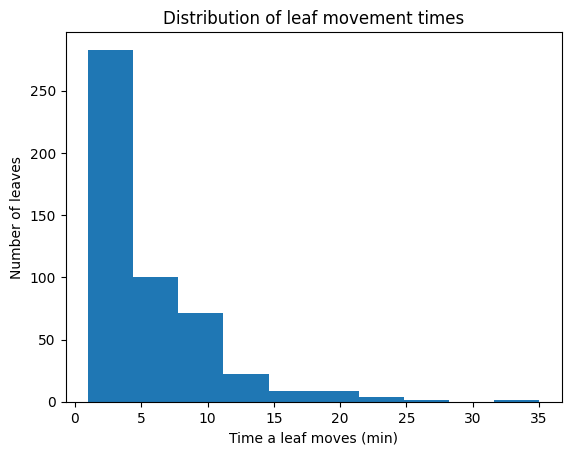

In [27]:
leaves = np.zeros(500)

for i in range(len(leaves)):
    for _ in range(100):
        leaves[i] += 1
        if np.random.randint(100) > 80:
            break

plt.hist(leaves)
plt.xlabel("Time a leaf moves (min)")
plt.ylabel("Number of leaves")
plt.title("Distribution of leaf movement times")
plt.show()


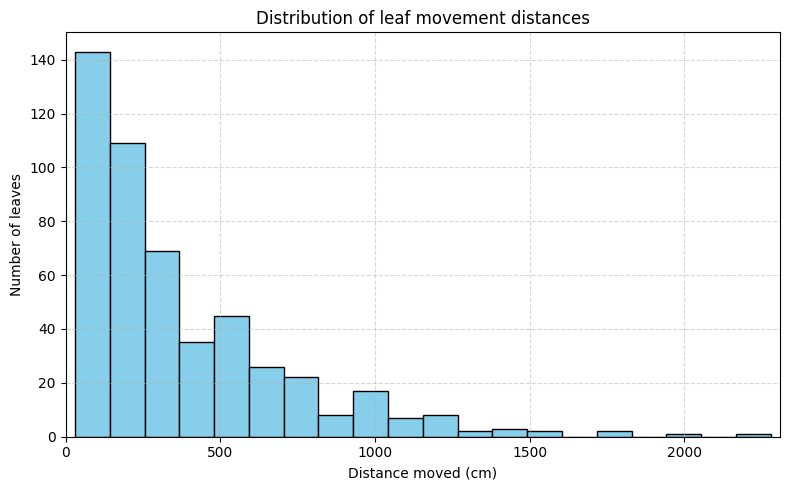

In [32]:
# Initialize 500 leaves
leaves = np.zeros(500)

# Simulate leaf movement
for i in range(len(leaves)):
    for _ in range(100):
        leaves[i] += 1
        if np.random.randint(100) > 91:  # ~8% chance of dropping at each step
            break

# Convert steps to distance: 1 step = 30 cm
leaves_distance = leaves * 30  # distance in cm

# Plot histogram
plt.figure(figsize=(8, 5))  # make the plot a bit larger
plt.hist(leaves_distance, bins=20, color='skyblue', edgecolor='black')

plt.xlabel("Distance moved (cm)")
plt.ylabel("Number of leaves")
plt.title("Distribution of leaf movement distances")

# Adjust x-axis limits dynamically
plt.xlim(0, np.max(leaves_distance) + 30)  # leave small margin at the right

plt.grid(True, linestyle='--', alpha=0.5)  # optional: add a grid
plt.tight_layout()  # improve spacing
plt.show()



with start (pickup probability

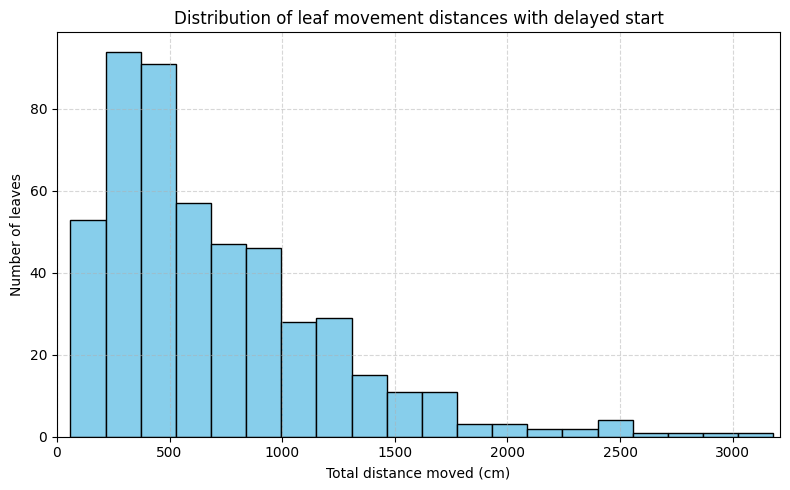

In [34]:
# Initialize 500 leaves
leaves = np.zeros(500)

# Simulate leaf movement
for i in range(len(leaves)):
    # First: waiting time before starting
    waiting_time = 0
    while True:
        waiting_time += 1
        if np.random.rand() < 0.10:  # 10% chance to start each minute
            break

    # Now start moving
    steps = 0
    for _ in range(100):
        steps += 1
        if np.random.randint(100) > 91:  # ~8% chance of dropping
            break

    # Total time = waiting time + movement time
    leaves[i] = (waiting_time + steps) * 30  # convert to distance (30 cm per min)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(leaves, bins=20, color='skyblue', edgecolor='black')

plt.xlabel("Total distance moved (cm)")
plt.ylabel("Number of leaves")
plt.title("Distribution of leaf movement distances with delayed start")
plt.xlim(0, np.max(leaves) + 30)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


repeated pickup

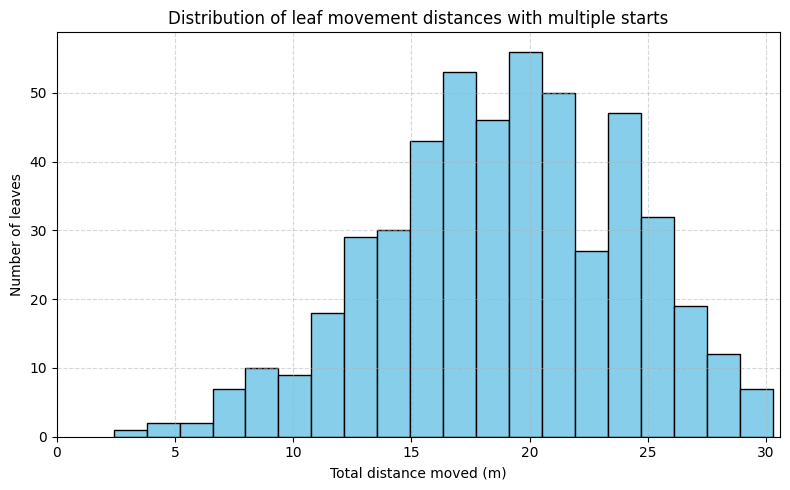

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize 500 leaves
leaves = np.zeros(500)

# Parameters
max_total_minutes = 120  # simulate for up to 1000 minutes
step_distance = 0.30  # m per minute

for i in range(len(leaves)):
    total_distance = 0
    total_minutes = 0

    while total_minutes < max_total_minutes:
        # Waiting phase before starting
        while True:
            total_minutes += 1
            if np.random.rand() < 0.10:  # 10% chance per minute to start
                break
            if total_minutes >= max_total_minutes:
                break

        if total_minutes >= max_total_minutes:
            break

        # Movement phase
        while True:
            total_distance += step_distance
            total_minutes += 1

            if np.random.randint(100) > 91:  # ~8% chance of dropping
                break

            if total_minutes >= max_total_minutes:
                break

    leaves[i] = total_distance

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(leaves, bins=20, color='skyblue', edgecolor='black')

plt.xlabel("Total distance moved (m)")
plt.ylabel("Number of leaves")
plt.title("Distribution of leaf movement distances with multiple starts")
plt.xlim(0, np.max(leaves) + step_distance)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


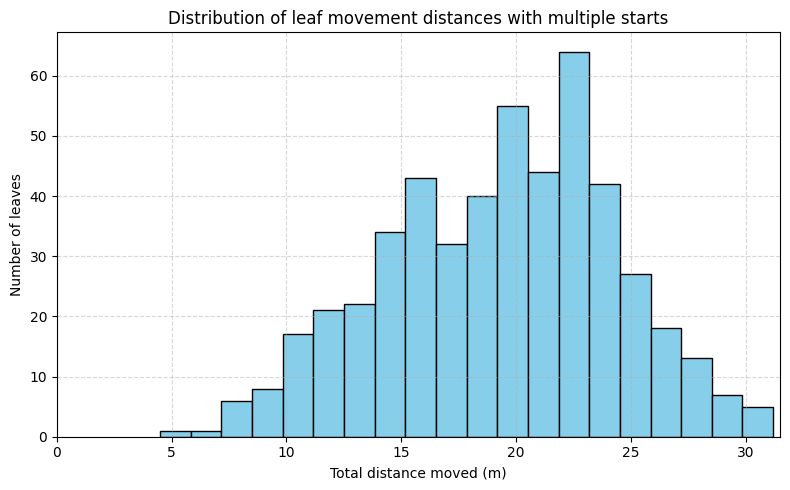

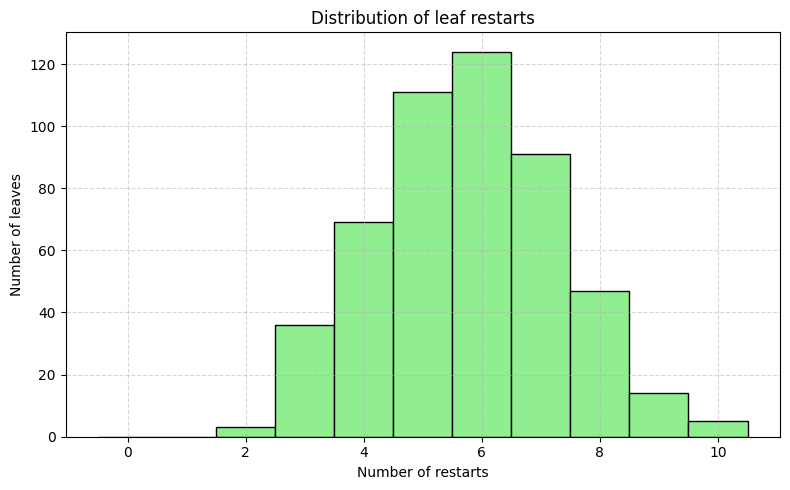

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize 500 leaves
leaves = np.zeros(500)
restarts = np.zeros(500)  # count restarts

# Parameters
max_total_minutes = 120  # simulate for up to 1000 minutes
step_distance = 0.30  # m per minute

for i in range(len(leaves)):
    total_distance = 0
    total_minutes = 0
    restart_count = 0

    while total_minutes < max_total_minutes:
        # Waiting phase before starting
        while True:
            total_minutes += 1
            if np.random.rand() < 0.10:  # 10% chance per minute to start
                restart_count += 1  # count restart when movement starts
                break
            if total_minutes >= max_total_minutes:
                break

        if total_minutes >= max_total_minutes:
            break

        # Movement phase
        while True:
            total_distance += step_distance
            total_minutes += 1

            if np.random.randint(100) > 91:  # ~8% chance of dropping
                break

            if total_minutes >= max_total_minutes:
                break

    leaves[i] = total_distance
    restarts[i] = restart_count

# Plot histogram of distances
plt.figure(figsize=(8, 5))
plt.hist(leaves, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Total distance moved (m)")
plt.ylabel("Number of leaves")
plt.title("Distribution of leaf movement distances with multiple starts")
plt.xlim(0, np.max(leaves) + step_distance)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot histogram of restart counts
plt.figure(figsize=(8, 5))
plt.hist(restarts, bins=range(int(restarts.max())+2), color='lightgreen', edgecolor='black', align='left')
plt.xlabel("Number of restarts")
plt.ylabel("Number of leaves")
plt.title("Distribution of leaf restarts")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


two types of leaves

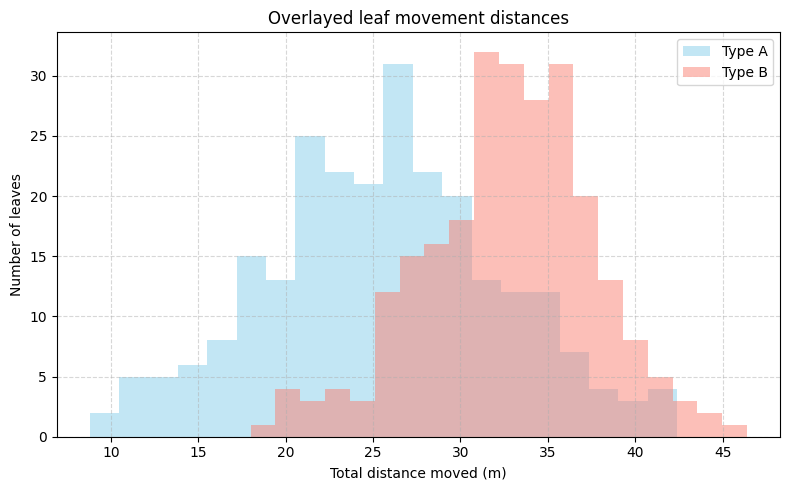

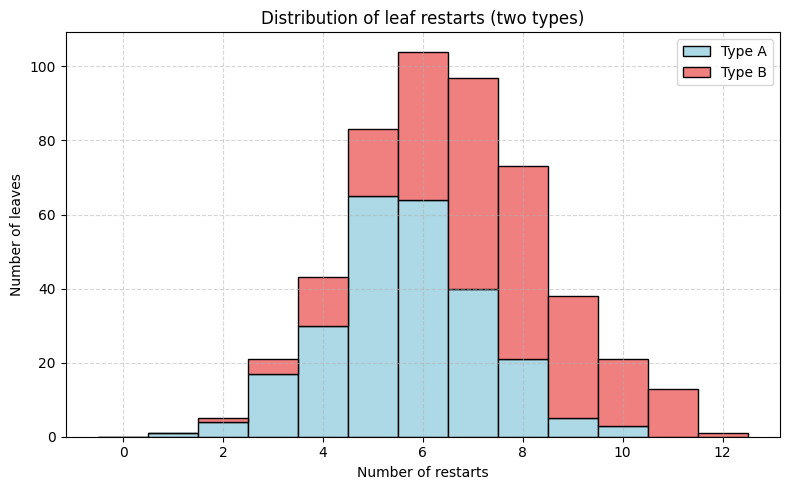

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
num_leaves_A = 250
num_leaves_B = 250
total_leaves = num_leaves_A + num_leaves_B

max_total_minutes = 120  # simulate for 120 minutes
step_distance = 0.4  # meters per minute

# Probabilities for Type A
start_prob_A = 0.10  # 10% chance per minute to start
drop_prob_A = 0.08   # 8% chance per minute to drop

# Probabilities for Type B
start_prob_B = 0.20  # 20% chance per minute to start
drop_prob_B = 0.08   # 8% chance per minute to drop

# Initialize arrays
leaves_distance = np.zeros(total_leaves)
restarts = np.zeros(total_leaves)

# Simulate for each leaf
for i in range(total_leaves):

    # Select which type the leaf is
    if i < num_leaves_A:
        start_prob = start_prob_A
        drop_prob = drop_prob_A
    else:
        start_prob = start_prob_B
        drop_prob = drop_prob_B

    total_distance = 0
    total_minutes = 0
    restart_count = 0

    while total_minutes < max_total_minutes:
        # Waiting phase
        while True:
            total_minutes += 1
            if np.random.rand() < start_prob:
                restart_count += 1
                break
            if total_minutes >= max_total_minutes:
                break

        if total_minutes >= max_total_minutes:
            break

        # Movement phase
        while True:
            total_distance += step_distance
            total_minutes += 1

            if np.random.rand() < drop_prob:
                break

            if total_minutes >= max_total_minutes:
                break

    leaves_distance[i] = total_distance
    restarts[i] = restart_count

# Plot histogram of distances
plt.figure(figsize=(8, 5))
plt.hist(leaves_distance[:num_leaves_A], bins=20, color='skyblue', alpha=0.5, label='Type A')
plt.hist(leaves_distance[num_leaves_A:], bins=20, color='salmon', alpha=0.5, label='Type B')
plt.xlabel("Total distance moved (m)")
plt.ylabel("Number of leaves")
plt.title("Overlayed leaf movement distances")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Plot histogram of restarts
plt.figure(figsize=(8, 5))
plt.hist([restarts[:num_leaves_A], restarts[num_leaves_A:]],
         bins=range(int(restarts.max())+2), stacked=True,
         label=['Type A', 'Type B'], color=['lightblue', 'lightcoral'],
         edgecolor='black', align='left')
plt.xlabel("Number of restarts")
plt.ylabel("Number of leaves")
plt.title("Distribution of leaf restarts (two types)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


leaves are arriving in the first hour, drawn from a normal distribution

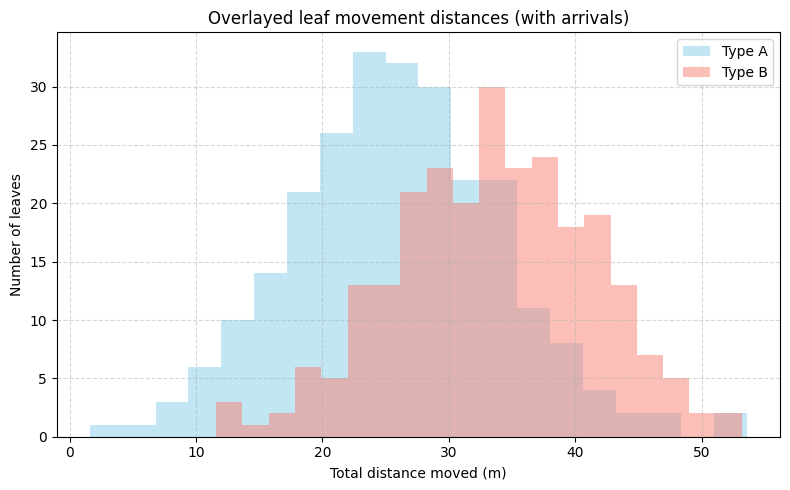

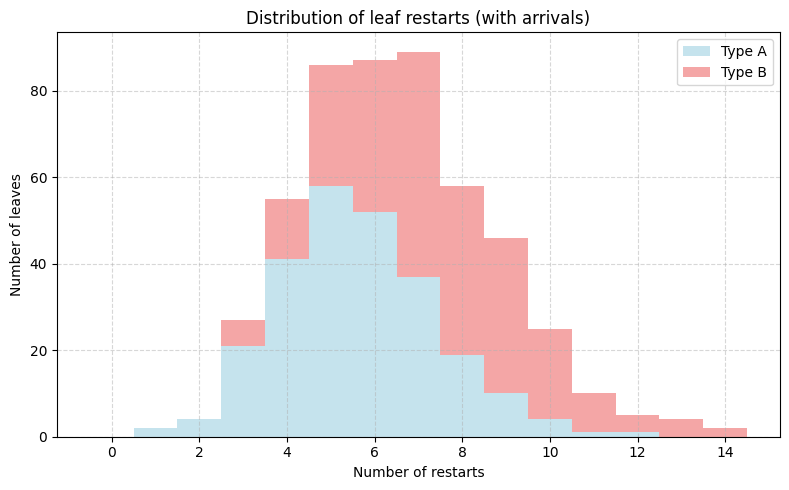

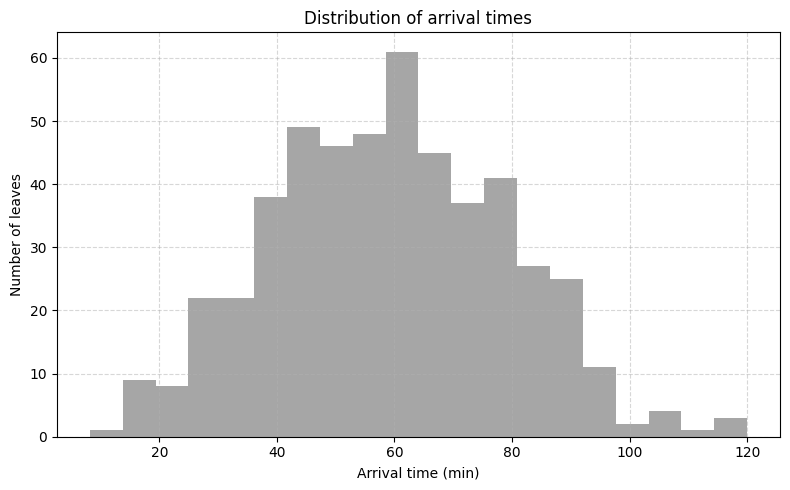

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
num_leaves_A = 250
num_leaves_B = 250
total_leaves = num_leaves_A + num_leaves_B

max_total_minutes = 180  # total simulation duration
step_distance = 0.4  # meters per minute

# Probabilities for Type A
start_prob_A = 0.10  # 10% chance per minute to start
drop_prob_A = 0.08   # 8% chance per minute to drop

# Probabilities for Type B
start_prob_B = 0.20  # 20% chance per minute to start
drop_prob_B = 0.08   # 8% chance per minute to drop

# Generate arrival times (normal distribution, clipped to 0-60 min)
arrival_mean = 60
arrival_std = 20
arrival_times = np.clip(np.random.normal(arrival_mean, arrival_std, total_leaves), 0, 120)

# Initialize arrays
leaves_distance = np.zeros(total_leaves)
restarts = np.zeros(total_leaves)

# Simulate for each leaf
for i in range(total_leaves):

    # Select type
    if i < num_leaves_A:
        start_prob = start_prob_A
        drop_prob = drop_prob_A
    else:
        start_prob = start_prob_B
        drop_prob = drop_prob_B

    total_distance = 0
    total_minutes = arrival_times[i]  # start counting after arrival
    restart_count = 0

    while total_minutes < max_total_minutes:
        # Waiting phase
        while True:
            total_minutes += 1
            if np.random.rand() < start_prob:
                restart_count += 1
                break
            if total_minutes >= max_total_minutes:
                break

        if total_minutes >= max_total_minutes:
            break

        # Movement phase
        while True:
            total_distance += step_distance
            total_minutes += 1

            if np.random.rand() < drop_prob:
                break

            if total_minutes >= max_total_minutes:
                break

    leaves_distance[i] = total_distance
    restarts[i] = restart_count

# Plot histogram of distances
plt.figure(figsize=(8, 5))
plt.hist(leaves_distance[:num_leaves_A], bins=20, color='skyblue', alpha=0.5, label='Type A')
plt.hist(leaves_distance[num_leaves_A:], bins=20, color='salmon', alpha=0.5, label='Type B')
plt.xlabel("Total distance moved (m)")
plt.ylabel("Number of leaves")
plt.title("Overlayed leaf movement distances (with arrivals)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot histogram of restarts
plt.figure(figsize=(8, 5))
plt.hist([restarts[:num_leaves_A], restarts[num_leaves_A:]],
         bins=range(int(restarts.max())+2), stacked=True,
         label=['Type A', 'Type B'], color=['lightblue', 'lightcoral'],
         align='left', alpha=0.7)
plt.xlabel("Number of restarts")
plt.ylabel("Number of leaves")
plt.title("Distribution of leaf restarts (with arrivals)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# (Optional: plot arrival distribution itself)
plt.figure(figsize=(8, 5))
plt.hist(arrival_times, bins=20, color='gray', alpha=0.7)
plt.xlabel("Arrival time (min)")
plt.ylabel("Number of leaves")
plt.title("Distribution of arrival times")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


a vectorized version might be next step

# Memory

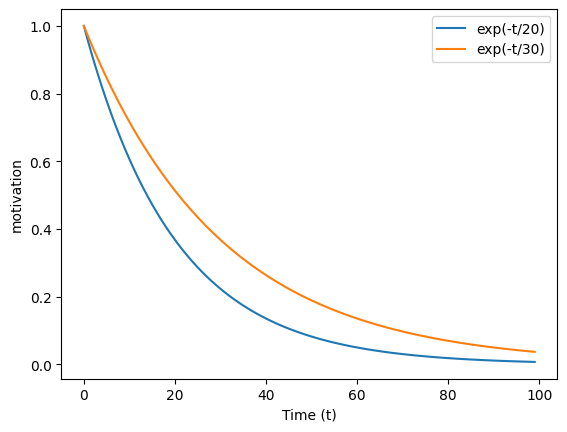

In [ ]:
t = np.arange(100)

# First plot
plt.plot(t, np.exp(-t/20), label="exp(-t/20)")

# Second plot — for example, a linear decay
plt.plot(t, np.exp(-t/30), label="exp(-t/30)")
# Add legend and labels (optional but good practice)
plt.xlabel("Time (t)")
plt.ylabel("motivation")
plt.legend()
plt.grid(False)

plt.show()

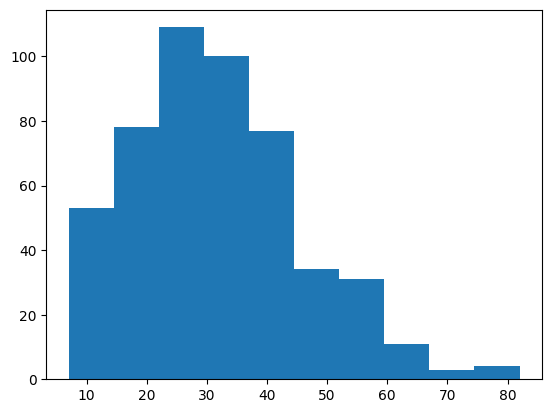

In [ ]:
leaves = np.zeros(500)
for i in range(len(leaves)):

    for t in np.arange(100):
        #step forward
        leaves[i] += 1
        motivation = 100 * np.exp(-t/500)
        if np.random.randint(0,100) > motivation:
            # DROP LEAF
            break

plt.hist(leaves);

# Reuptake and memory

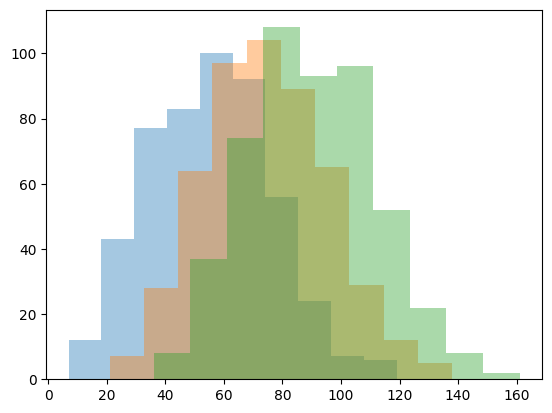

In [ ]:
leaves = np.zeros(500)

leaf_moves = np.zeros_like(leaves)
for t in np.arange(1000):
    for i in range(len(leaves)):
        if leaf_moves[i]:
            #step forward
            leaves[i] += 1
            # demotivator
            motivation = 100 * np.exp(-t/500)
            if  motivation < np.random.randint(0,100):
                # DROP LEAF
                leaf_moves[i] = False
        else:
            if np.random.randint(0,100) > 95:
                leaf_moves[i] = True

    if t%300==299:
        plt.hist(leaves, alpha=0.4);
        #print(t)

**Playground**

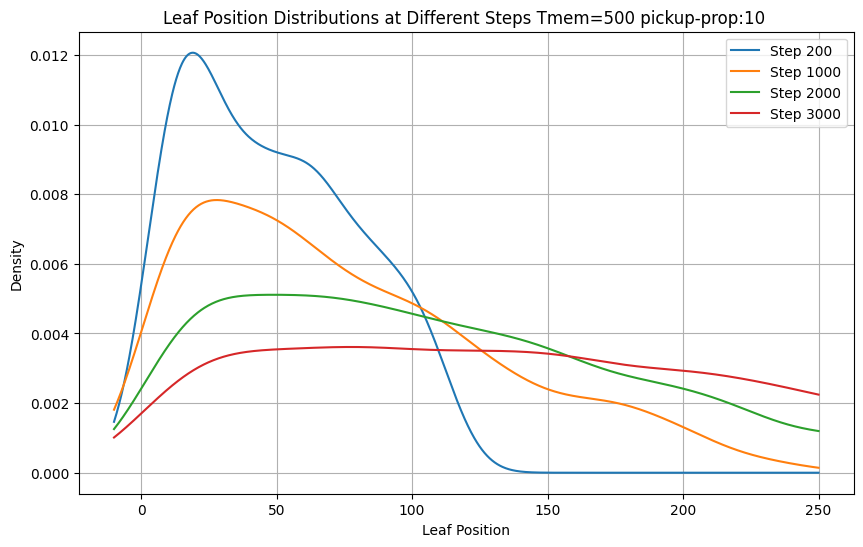

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Initial leaf setup
leaves = np.zeros(50)
leaf_moves = np.zeros_like(leaves, dtype=bool)

# Parameters for new leaf generation
generation_interval = 50
leaves_per_generation = 50
generation_mean = 0                # Keep around zero
generation_std = 0.5               # Small spread

# Checkpoints to store snapshots
checkpoints = [199, 999, 1999, 2999]
leaf_positions_at_checkpoints = []

Tmem = 500
PickP = 10

for t in range(3000):
    motivation = 100 * np.exp(-t / Tmem)

    # Move active leaves
    moving = leaf_moves
    leaves[moving] += 1

    # Drop some moving leaves
    drop_mask = np.random.randint(0, 100, size=moving.sum()) > motivation
    leaf_moves[np.where(moving)[0][drop_mask]] = False

    # Randomly activate stationary leaves
    start_mask = (~leaf_moves) & (np.random.randint(0, 100, size=len(leaves)) > 100 - PickP)
    leaf_moves[start_mask] = True

    # Generate new leaves near zero every interval
    if t % generation_interval == 0:
        new_positions = np.random.normal(loc=0, scale=generation_std, size=leaves_per_generation)
        leaves = np.concatenate([leaves, new_positions])
        leaf_moves = np.concatenate([leaf_moves, np.zeros(leaves_per_generation, dtype=bool)])

    if t in checkpoints:
        leaf_positions_at_checkpoints.append(leaves.copy())

# Plot the KDEs
plt.figure(figsize=(10, 6))

labels = [f"Step {cp + 1}" for cp in checkpoints]
x_vals = np.linspace(- 10, 250, 1100)

#x_vals = np.linspace(leaves.min() - 10, leaves.max() + 10, 1100)

for i, positions in enumerate(leaf_positions_at_checkpoints):
    kde = gaussian_kde(positions)
    plt.plot(x_vals, kde(x_vals), label=labels[i])

plt.title(f"Leaf Position Distributions at Different Steps {Tmem=} pickup-prop:{PickP} ")
plt.xlabel("Leaf Position")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


generate leaves

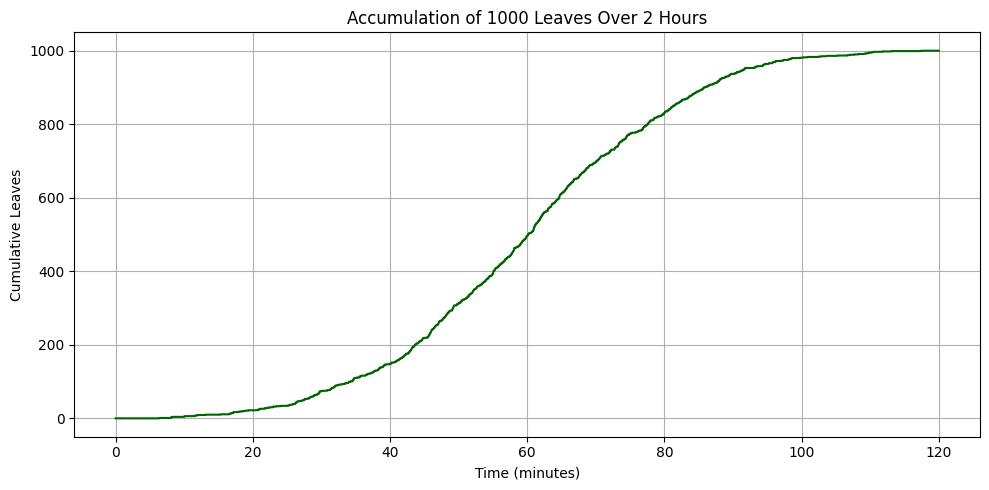

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Simulation setup ---
duration_seconds = 2 * 60 * 60  # 2 hours = 7200 seconds
time = np.arange(duration_seconds)

# Gaussian shape for generation probability (peaks at 1 hour)
peak_time = duration_seconds / 2
std_dev = duration_seconds / 6  # wide spread (~2 std covers the 2-hour span)

# Probability density (not yet normalized)
pdf = np.exp(-0.5 * ((time - peak_time) / std_dev) ** 2)
pdf /= pdf.sum()  # normalize to sum to 1

# Total leaves to generate
total_leaves = 1000

# Generate number of leaves per second using multinomial distribution
leaf_counts_per_sec = np.random.multinomial(total_leaves, pdf)

# Accumulate
cumulative_leaves = np.cumsum(leaf_counts_per_sec)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(time / 60, cumulative_leaves, color='darkgreen')
plt.title("Accumulation of 1000 Leaves Over 2 Hours")
plt.xlabel("Time (minutes)")
plt.ylabel("Cumulative Leaves")
plt.grid(True)
plt.tight_layout()
plt.show()
